## Get data

We'll download one file from https://zenodo.org/record/4650317.
This only needs to be executed once.

In [1]:
!mkdir -p data/
!curl \
    -o data/trajectories_stokes_subset_10000.csv.gz \
    https://zenodo.org/record/4650317/files/trajectories_stokes_subset_10000.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  244M  100  244M    0     0  5388k      0  0:00:46  0:00:46 --:--:-- 5613k


## Load data and extract a few trajectories

In [2]:
import numpy as np
import pandas as pd

In [3]:
def load_and_subset_trajectories(
    file_name, num_traj=300, use_random=False
):

    df = pd.read_csv(file_name)

    # the whole dataset is too big to open here.
    if use_random:
        # Let's subset to fewer random trajectories:
        random_trajs = np.random.choice(
            np.unique(df["traj"]), num_traj, replace=False
        )
        traj_mask = df["traj"].apply(lambda x: x in random_trajs)
    else:
        # Let's use the first N trajectories
        first_n_trajs = np.unique(df["traj"])[:num_traj]
        traj_mask = df["traj"].apply(lambda x: x in first_n_trajs)
    
    df = df[traj_mask]
    
    return df

In [4]:
df = load_and_subset_trajectories("data/trajectories_stokes_subset_10000.csv.gz")

In [5]:
df = df.set_index(["traj", "obs"]).sort_index(level=0)
df

MPA    distance  land        lat       lon       temp  \
traj obs                                                          
0    0    1.0    0.000000   0.0  43.288517  5.171321  13.421764   
     1    1.0    0.843716   0.0  43.285854  5.181101  13.429676   
     2    1.0    1.645409   0.0  43.283524  5.190491  13.436654   
     3    1.0    2.403811   0.0  43.281498  5.199454  13.442868   
     4    1.0    3.123281   0.0  43.279760  5.208031  13.448405   
...       ...         ...   ...        ...       ...        ...   
299  957  0.0  624.659500   0.0  40.176200  6.797083  25.572657   
     958  0.0  625.336400   0.0  40.174015  6.804533  25.578049   
     959  0.0  626.014160   0.0  40.172066  6.812105  25.583246   
     960  0.0  626.696200   0.0  40.170307  6.819810  25.588346   
     961  0.0  626.753300   0.0  40.170166  6.820457  25.588772   

                         time         z  
traj obs                                 
0    0             2017-03-01  1.018237  
     1    2017-03-01 01:00:00  1.018237  
     2    2017-03-01 02:00:00  1.018237  
     3    2017-03-01 03:00:00  1.018237  
     4    2017-03-01 04:00:00  1.018237  
...                       ...       ...  
299  957  2017-08-13 21:00:00  1.018237  
     958  2017-08-13 22:00:00  1.018237  
     959  2017-08-13 23:00:00  1.018237  
     960  2017-08-14 00:00:00  1.018237  
     961           2017-08-14  1.018237  

[288600 rows x 8 columns]

In [6]:
df = df[["lat", "lon"]]
df

lat       lon
traj obs                     
0    0    43.288517  5.171321
     1    43.285854  5.181101
     2    43.283524  5.190491
     3    43.281498  5.199454
     4    43.279760  5.208031
...             ...       ...
299  957  40.176200  6.797083
     958  40.174015  6.804533
     959  40.172066  6.812105
     960  40.170307  6.819810
     961  40.170166  6.820457

[288600 rows x 2 columns]

## Calculate the distance between trajectories

We'll use https://github.com/roy-ht/editdistance and compare all trajectories to the first one in the data set.
More on the edit or Levenshtein distance here: https://en.wikipedia.org/wiki/Levenshtein_distance

### Discretize positions

In [7]:
num_bins_lat = 10
num_bins_lon = 30

lat_bins = np.linspace(df["lat"].min(), df["lat"].max(), num_bins_lat)
lon_bins = np.linspace(df["lon"].min(), df["lon"].max(), num_bins_lon)

In [8]:
df["lat_bin"] = np.digitize(df["lat"], lat_bins, right=True)
df["lon_bin"] = np.digitize(df["lon"], lon_bins, right=True)

df["bin_tup"] = list(zip(df["lat_bin"], df["lon_bin"]))

df["lat_bin_pos"] = lat_bins[np.digitize(df["lat"], lat_bins, right=True)] - 0.5 * np.diff(lat_bins)[0]
df["lon_bin_pos"] = lon_bins[np.digitize(df["lon"], lon_bins, right=True)] - 0.5 * np.diff(lon_bins)[0]

df

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

lat       lon  lat_bin  lon_bin  bin_tup  lat_bin_pos  \
traj obs                                                                
0    0    43.288517  5.171321        9       15  (9, 15)    43.215361   
     1    43.285854  5.181101        9       15  (9, 15)    43.215361   
     2    43.283524  5.190491        9       15  (9, 15)    43.215361   
     3    43.281498  5.199454        9       15  (9, 15)    43.215361   
     4    43.279760  5.208031        9       15  (9, 15)    43.215361   
...             ...       ...      ...      ...      ...          ...   
299  957  40.176200  6.797083        3       21  (3, 21)    40.146547   
     958  40.174015  6.804533        3       21  (3, 21)    40.146547   
     959  40.172066  6.812105        3       21  (3, 21)    40.146547   
     960  40.170307  6.819810        3       21  (3, 21)    40.146547   
     961  40.170166  6.820457        3       21  (3, 21)    40.146547   

          lon_bin_pos  
traj obs               
0    0       5.264897  
     1       5.264897  
     2       5.264897  
     3       5.264897  
     4       5.264897  
...               ...  
299  957     6.771288  
     958     6.771288  
     959     6.771288  
     960     6.771288  
     961     6.771288  

[288600 rows x 7 columns]

In [9]:
ref_traj = 6

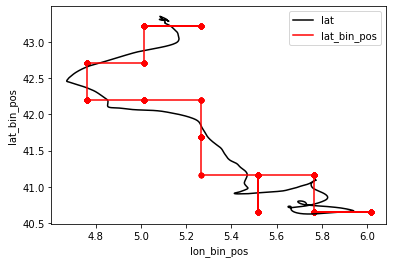

In [10]:
ax = df.loc[ref_traj].plot.line(x="lon", y="lat", c="k")
df.loc[ref_traj].plot.scatter(x="lon_bin_pos", y="lat_bin_pos", c="r", ax=ax);
df.loc[ref_traj].plot.line(x="lon_bin_pos", y="lat_bin_pos", c="r", ax=ax);

## Calculate the distance

In [13]:
from editdistance import distance as edist

In [14]:
df.loc[df.index.levels[0][ref_traj]]

,lat,lon,lat_bin,lon_bin,bin_tup,lat_bin_pos,lon_bin_pos
obs,,,,,,,
0,43.302692,5.095328,9,14,"(9, 14)",43.215361,5.013832
1,43.304523,5.093338,9,14,"(9, 14)",43.215361,5.013832
2,43.306070,5.091500,9,14,"(9, 14)",43.215361,5.013832
3,43.307220,5.089628,9,14,"(9, 14)",43.215361,5.013832
4,43.308200,5.087857,9,14,"(9, 14)",43.215361,5.013832
...,...,...,...,...,...,...,...
957,40.769650,5.731543,4,17,"(4, 17)",40.658016,5.767027
958,40.763980,5.732437,4,17,"(4, 17)",40.658016,5.767027
959,40.758140,5.733198,4,17,"(4, 17)",40.658016,5.767027


In [15]:
dist_to_ref = np.array([
    edist(
        df.loc[traj]["bin_tup"],
        df.loc[df.index.levels[0][ref_traj]]["bin_tup"]
    )
    for traj in df.index.levels[0]
])

In [16]:
from matplotlib import pyplot as plt

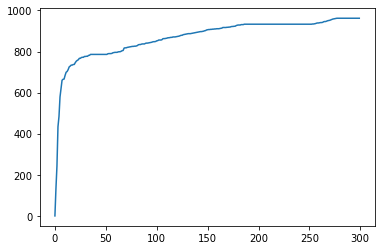

In [17]:
plt.plot(np.sort(dist_to_ref))

In [18]:
trajs_close_to_ref = df.index.levels[0][dist_to_ref < 750]
trajs_close_to_ref

Int64Index([  6,   7,   8,  40,  53,  62,  73,  76, 132, 155, 163, 164, 176,
            197, 200, 210, 220, 226, 244, 259, 277],
           dtype='int64', name='traj')

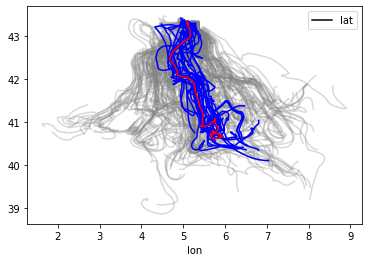

In [19]:
ax = df.loc[trajs_close_to_ref[0]].plot.line(x="lon", y="lat", c="k")
for traj in df.index.levels[0]:
    df.loc[traj].plot.line(x="lon", y="lat", c="gray", alpha=0.3, ax=ax, legend=False)
for traj in trajs_close_to_ref:
    df.loc[traj].plot.line(x="lon", y="lat", c="blue", ax=ax, legend=False)
df.loc[trajs_close_to_ref[0]].plot.line(x="lon", y="lat", c="r", ax=ax, legend=False)